# Setup

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.metrics.pairwise

import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
import umap

In [2]:
# Read preprocessed CSV file
df = pd.read_csv("all_letters.csv", sep="\t", header=None)
df.columns = ["Nb", "Author", "Content"]

# Analysis 1: Do letters become "more similar" to each other over time?

In [59]:
def fit_model(df=df, n_gram_n = 1, min_word_length = 3, normalise_counts = False, binary = False):
    # We will fit a bag of words model with n-grams, consisting of l+ letters only
    
    # normalise_counts: Norm word counts across the letters?
    
    # binary: Binary presence-absence data instead of frequencies?
    # Apparently, this does not alter results qualitatively,
    # regardless of whether wie normalise word counts or not
    
    # Model fitting
    token_pattern = "[a-zA-Z]{" + str(min_word_length) + ",100000}"
    model = CountVectorizer(ngram_range=(n_gram_n,n_gram_n), token_pattern=token_pattern, binary=binary)
    X = model.fit_transform(df.Content)
    X = X.toarray()
    print(model.get_feature_names()[:100])

    # Norming words if desired
    if normalise_counts:
        X = (X - X.mean(axis=0)) / X.std(axis=0)

    # Compute cosine similarity matrix on the individual letters (i.e. vectors)
    cosinesim = sklearn.metrics.pairwise.cosine_similarity(X)

    return X, cosinesim


In [60]:
X, cosinesim = fit_model()

['abb', 'abbestellen', 'abbestellt', 'abbestellte', 'abbestellungen', 'abbetet', 'abbildung', 'abbildungen', 'abbitte', 'abbrannte', 'abbrechen', 'abbruch', 'abdestillirt', 'abdr', 'abdruck', 'abdrucken', 'abdrucker', 'abend', 'abendanfrage', 'abendd', 'abende', 'abenden', 'abendessen', 'abendgesellschaft', 'abendgespr', 'abendluft', 'abendmahlzeit', 'abendpost', 'abends', 'abendspost', 'abendstunde', 'abendstunden', 'abendvorlesung', 'abendzeit', 'abenteuer', 'abenteuerlichen', 'abenteuern', 'aber', 'abergl', 'aberglaube', 'aberglauben', 'aberglaubens', 'abermalige', 'abermaligen', 'abermals', 'abf', 'abfahren', 'abfahrt', 'abfall', 'abfertigen', 'abfertigt', 'abfertigung', 'abfordern', 'abg', 'abgang', 'abge', 'abgeben', 'abgeborgt', 'abgebrochen', 'abgedruckt', 'abgedruckten', 'abgef', 'abgefallen', 'abgefertigt', 'abgefordert', 'abgegangen', 'abgegangene', 'abgegeben', 'abgehalten', 'abgehandelt', 'abgehen', 'abgehenden', 'abgehn', 'abgeht', 'abgek', 'abgel', 'abgelassen', 'abgelau

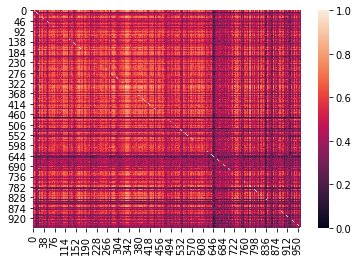

In [61]:
# Plot it
sns.heatmap(cosinesim)

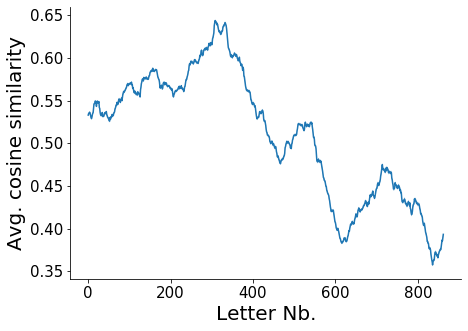

In [62]:
# We now slide a window of size 'window_size' over the 963 letters
# and compute the average pairwise cosine similarity 
window_size = 100

avg_similarities = []
se_similarities = []
nb_letter = range(0, len(cosinesim)-window_size)
for i in nb_letter:
    # Extract the similarity values from the triangular submatrix
    # from i to i+windowsize, excluding the 1s on diagonal
    submatrix = cosinesim[i:i+window_size,i:i+window_size]
    similarities = submatrix[np.triu_indices(window_size, k=1)]
    
    # Compute avg and sem
    avg_similarities.append(np.mean(similarities))
    se_similarities.append(sp.stats.sem(similarities))
avg_similarities = np.array(avg_similarities)
se_similarities = np.array(se_similarities)

# Generate plot and make visually more pleasing
fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.set_xlabel("Letter Nb.", size=20)
ax.set_ylabel("Avg. cosine similarity", size=20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.plot(nb_letter, avg_similarities)
ax.fill_between(nb_letter, avg_similarities-se_similarities, avg_similarities+se_similarities, alpha=.5)

# Analysis 2: Embedding of letters

[0.01446648 0.01073127]


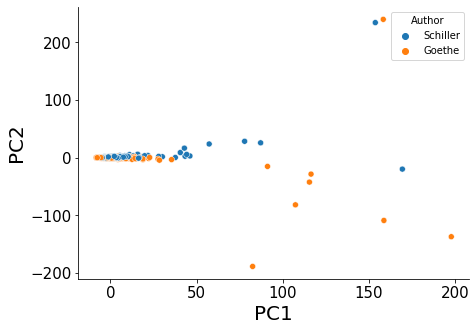

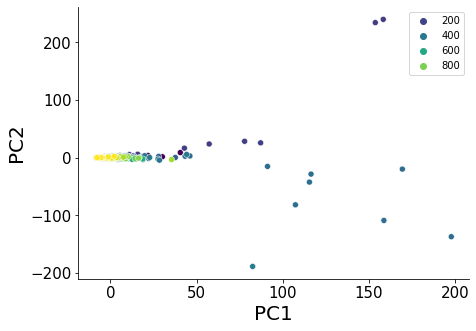

In [58]:
# First attempt: PCA
# Does not produce a clear picture, regardless of whether
# we normalise that word counts before or not

pca = PCA(n_components=2)
Y = pca.fit_transform(X)
print(pca.explained_variance_ratio_)

fig, ax = plt.subplots(1,1,figsize=(7,5))
sns.scatterplot(x=Y[:,0], y=Y[:,1], ax=ax, hue=df.Author)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("PC1", size=20)
ax.set_ylabel("PC2", size=20)
plt.show()

fig, ax = plt.subplots(1,1,figsize=(7,5))
sns.scatterplot(x=Y[:,0], y=Y[:,1], ax=ax, hue=[float(x) for x in df.Nb], palette="viridis")
ax.tick_params(axis='both', which='major', labelsize=15)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("PC1", size=20)
ax.set_ylabel("PC2", size=20)
plt.show()

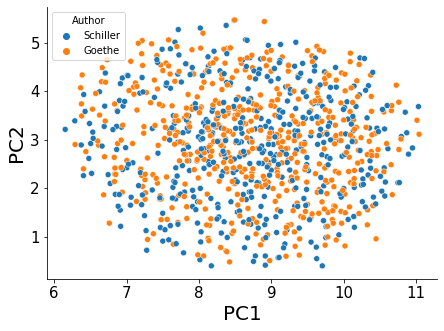

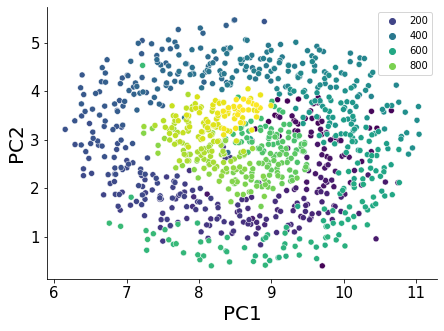

In [40]:
# Second attempt: umap
# Not a clear picture either, regardless of whether we
# normalise word counts or not

reducer = umap.UMAP()
Y = reducer.fit_transform(X)

fig, ax = plt.subplots(1,1,figsize=(7,5))
sns.scatterplot(x=Y[:,0], y=Y[:,1], ax=ax, hue=df.Author)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("PC1", size=20)
ax.set_ylabel("PC2", size=20)
plt.show()

fig, ax = plt.subplots(1,1,figsize=(7,5))
sns.scatterplot(x=Y[:,0], y=Y[:,1], ax=ax, hue=[float(x) for x in df.Nb], palette="viridis")
ax.tick_params(axis='both', which='major', labelsize=15)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("PC1", size=20)
ax.set_ylabel("PC2", size=20)
plt.show()